<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Jose Leonardo Aceves Gonzalez y María Fernanda Amador Alvarez.

**Fecha:** 27 de noviembre del 2021.

**Expediente** : 712626 y 725573.
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/feramdor/Tarea9-10_Amdor_Aceves
# Tarea 9: Clase 23

Implementar el método de esquemas del trapecio, para valuar la opción call y put asiática con precio inicial, $S_0 = 100$, precio de ejercicio $K = 100$, tasa libre de riesgo $r = 0.10$, volatilidad $\sigma = 0.20$ y $T = 1$ año. Cuyo precio es $\approx 7.04$. Realizar la simulación en base a la siguiente tabla:
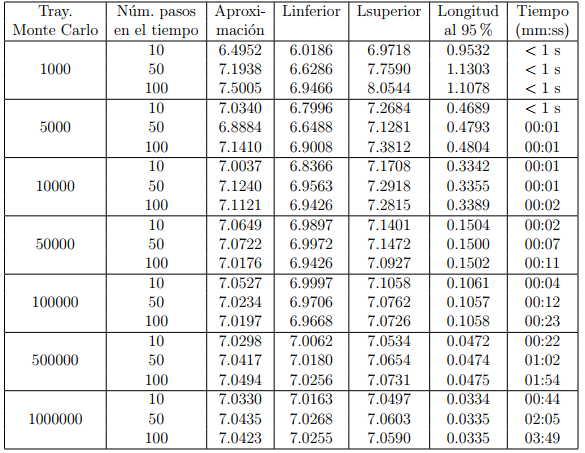

Observe que en esta tabla se encuentran los intervalos de confianza de la aproximación obtenida y además el tiempo de simulación que tarda en encontrar la respuesta cada método. 
- Se debe entonces realizar una simulación para la misma cantidad de trayectorias y número de pasos y construir una Dataframe de pandas para reportar todos los resultados obtenidos.**(70 puntos)**
- Compare los resultados obtenidos con los resultados arrojados por la función `Riemann_approach`. Concluya. **(30 puntos)**

### Estudiante 1: Fernanda Amador 

In [1]:
# Librerías
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime
from time import time
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns; sns.set()
%matplotlib inline
#algunas opciones para Pandas
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [2]:
# Funciones opción call
def BSprices(mu,
             sigma,
             S0,
             NbTraj,
             NbStep):
   
    # Datos para la fórmula de St
    nu = mu-(sigma**2)/2
    DeltaT = 1/NbStep
    SqDeltaT = np.sqrt(DeltaT)
    DeltaW = SqDeltaT*np.random.randn(NbTraj,NbStep-1)
    
    # Se obtiene --> Ln St = Ln S0+ nu*DeltaT + sigma*DeltaW
    increments = nu*DeltaT + sigma*DeltaW
    concat = np.concatenate((np.log(S0)*np.ones([NbTraj,1]),increments),axis=1)
    
    # Se utiliza cumsum por que se quiere simular los precios iniciando desde S0
    LogSt = np.cumsum(concat,axis=1)
    # Se obtienen los precios simulados para los NbStep fijados
    St = np.exp(LogSt)
    # Vector con la cantidad de días simulados
    t = np.arange(0,NbStep)

    return St.T,t

def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).iloc[1:]

In [3]:
def call_asiatica_trap(K:'Strike price',
                       r:'Tasa libre de riesgo',
                       S0:'Precio inicial',
                       NbTraj:'Número trayectorias',
                       NbStep:'Cantidad de pasos a simular',
                       sigma:'Volatilidad',
                       T:'Tiempo de cierre del contrato'):
    
    # Iniciar Tiempo
    tiempo_in = time()
    
    # precios mediante black and scholes
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    prices = pd.DataFrame(St,index=t) #DataFrame de precios
    
    # precios promedio
    h = T/NbStep
    Av_t = np.cumsum(prices * (2+r*h+np.random.randn(NbStep,NbTraj)*sigma))*h/(2*T)
    
    strike = K
    # Calculamos el call
    valuacion = pd.DataFrame({'Prima': np.exp(-r*T)*np.fmax(Av_t - strike, 0).mean(axis=1)}, index=t)
    
    # intervalos de confianza
    conf = 0.95
    i = st.norm.interval(conf, loc = valuacion.iloc[-1].Prima, scale = valuacion.sem().Prima)
    
    
    tiempo_fin = time()
    tiempo_total = tiempo_fin - tiempo_in
    
    # regresar prima, intervalos de confianza, rango de intervalos  y tiempo
    return np.array([valuacion.iloc[-1].Prima,i[0],i[1],i[1]-i[0],tiempo_total])

In [4]:
# Valores de la opcion 
S0 = 100
K = 100
r = 0.1
sigma = 0.2
T = 1

# Trayectorias monte carlo
NbTraj = [1000,5000,10000,50000,100000,500000,1000000]

# Pasos en el tiempo
NbStep = [10,50,100]

In [5]:
# Opción Call
call = list(map(lambda trayectorias:list(map(lambda pasos: 
                                             call_asiatica_trap(K,r,S0,trayectorias,pasos,sigma,T),NbStep)), NbTraj))

In [6]:
# niveles por index
n = 3 

# indice posicion de cada rango
i1 =list(map(lambda i: int(i/n),range(7*n)))

# posicion de cada sub rango
i2 =list(map(lambda i: int(i%n),range(7*n)))

# index del data frame
indx = pd.MultiIndex(levels=[NbTraj,NbStep], codes=[i1, i2])

call_array = np.array([call[i1[i]][i2[i]] for i in range(len(i1))])

call_aprox = np.array([i[0] for i in call_array]) # aproximacion

# limite inferior
lim_inf = np.array([i[1] for i in call_array])

# limite superior
lim_sup = np.array([i[2] for i in call_array])

# rango de limites 
rango = np.array([i[3] for i in call_array])

# obtener tiempos
tiempos_call = np.array([i[4] for i in call_array])


# General DataFrame
tabla_call = pd.DataFrame(index = indx,columns = ['Aproximacion','Linferior','Lsuperior','Longitud 95%','Tiempo'])
tabla_call.index.names = (['Tray. Monte Carlo','Num. pasos en el tiempo'])
tabla_call['Aproximacion'] = call_aprox
tabla_call['Linferior'] = lim_inf
tabla_call['Lsuperior'] = lim_sup
tabla_call['Longitud 95%'] = rango
tabla_call['Tiempo'] = np.round(tiempos_call,2)

In [7]:
pd.set_option('display.max_rows', 
              None, 
              'display.max_columns', 
              None)
tabla_call

Aproximacion  Linferior  \
Tray. Monte Carlo Num. pasos en el tiempo                            
1000              10                              6.790      5.461   
                  50                              6.886      6.480   
                  100                             6.845      6.580   
5000              10                              6.822      5.484   
                  50                              6.971      6.559   
                  100                             7.226      6.941   
10000             10                              6.746      5.423   
                  50                              6.883      6.478   
                  100                             6.954      6.680   
50000             10                              6.872      5.524   
                  50                              6.951      6.541   
                  100                             7.006      6.730   
100000            10                              6.903      5.549   
                  50                              7.037      6.622   
                  100                             7.042      6.764   
500000            10                              6.910      5.554   
                  50                              7.032      6.617   
                  100                             7.018      6.742   
1000000           10                              6.900      5.546   
                  50                              7.018      6.604   
                  100                             7.031      6.754   

                                           Lsuperior  Longitud 95%  Tiempo  
Tray. Monte Carlo Num. pasos en el tiempo                                   
1000              10                           8.120         2.660    0.06  
                  50                           7.292         0.812    0.05  
                  100                          7.110         0.529    0.02  
5000              10                           8.160         2.676    0.01  
                  50                           7.384         0.824    0.19  
                  100                          7.510         0.569    0.23  
10000             10                           8.070         2.647    0.03  
                  50                           7.287         0.810    0.16  
                  100                          7.228         0.548    0.38  
50000             10                           8.220         2.696    0.20  
                  50                           7.362         0.820    1.77  
                  100                          7.281         0.551    3.13  
100000            10                           8.257         2.708    0.37  
                  50                           7.453         0.831    1.82  
                  100                          7.319         0.554    3.87  
500000            10                           8.265         2.710    1.48  
                  50                           7.447         0.831    9.80  
                  100                          7.293         0.552   23.37  
1000000           10                           8.253         2.706    2.05  
                  50                           7.433         0.829   16.61  
                  100                          7.307         0.553   44.46

In [8]:
# Funciones opción put
def put_asiatica_trap(K:'Strike price',
                      r:'Tasa libre de riesgo',
                      S0:'Precio inicial',
                      NbTraj:'Número trayectorias',
                      NbStep:'Cantidad de pasos a simular',
                      sigma:'Volatilidad',
                      T:'Tiempo de cierre del contrato'):
    
    # Iniciar Tiempo
    tiempo_in = time()
    
    # precios mediante black and scholes
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    prices = pd.DataFrame(St,index=t) #DataFrame de precios
    
    # precios promedio
    h = T/NbStep
    Av_t = np.cumsum(prices * (2+r*h+np.random.randn(NbStep,NbTraj)*sigma))*h/(2*T)
    
    strike = K
    # Calculamos put
    valuacion = pd.DataFrame({'Prima': np.exp(-r*T)*np.fmax(strike - Av_t , 0).mean(axis=1)}, index=t)
    
    # intervalos de confianza
    conf = 0.95
    i = st.norm.interval(conf, loc = valuacion.iloc[-1].Prima, scale = valuacion.sem().Prima)
    
    
    tiempo_fin = time()
    tiempo_total = tiempo_fin - tiempo_in
    
    # regresar prima, intervalos de confianza, rango de intervalos  y tiempo
    return np.array([valuacion.iloc[-1].Prima,i[0],i[1],i[1]-i[0],tiempo_total])

In [9]:
put = list(map(lambda trayectorias:list(map(lambda pasos: 
                                             put_asiatica_trap(K,r,S0,trayectorias,pasos,sigma,T),NbStep)), NbTraj))

In [10]:
# niveles por index
n = 3 

# indice posicion de cada rango
i1 =list(map(lambda i: int(i/n),range(7*n)))

# posicion de cada sub rango
i2 =list(map(lambda i: int(i%n),range(7*n)))

# index del data frame
indx = pd.MultiIndex(levels=[NbTraj,NbStep], codes=[i1, i2])

put_array = np.array([put[i1[i]][i2[i]] for i in range(len(i1))])

put_aprox = np.array([i[0] for i in put_array]) # aproximacion

# limite inferior
lim_inf_p = np.array([i[1] for i in put_array])

# limite superior
lim_sup_p = np.array([i[2] for i in put_array])

# rango de limites 
rango = np.array([i[3] for i in put_array])

# obtener tiempos
tiempos_put = np.array([i[4] for i in put_array])


# General DF
tabla_put = pd.DataFrame(index = indx, columns = ['Aproximacion','Linferior','Lsuperior','Longitud 95%','Tiempo'])
tabla_put.index.names = (['Tray. Monte Carlo','Num. pasos en el tiempo'])
tabla_put['Aproximacion'] = put_aprox
tabla_put['Linferior'] = lim_inf_p
tabla_put['Lsuperior'] = lim_sup_p
tabla_put['Longitud 95%'] = rango
tabla_put['Tiempo'] = np.round(tiempos_put,2)

In [11]:
tabla_put

Aproximacion  Linferior  \
Tray. Monte Carlo Num. pasos en el tiempo                            
1000              10                              2.019    -15.167   
                  50                              2.550     -4.882   
                  100                             2.184     -3.092   
5000              10                              2.286    -14.804   
                  50                              2.401     -5.050   
                  100                             2.352     -2.902   
10000             10                              2.141    -14.993   
                  50                              2.272     -5.197   
                  100                             2.394     -2.860   
50000             10                              2.268    -14.831   
                  50                              2.349     -5.110   
                  100                             2.347     -2.910   
100000            10                              2.227    -14.893   
                  50                              2.330     -5.133   
                  100                             2.351     -2.905   
500000            10                              2.240    -14.873   
                  50                              2.345     -5.115   
                  100                             2.354     -2.903   
1000000           10                              2.231    -14.884   
                  50                              2.332     -5.130   
                  100                             2.352     -2.905   

                                           Lsuperior  Longitud 95%  Tiempo  
Tray. Monte Carlo Num. pasos en el tiempo                                   
1000              10                          19.206        34.373    0.02  
                  50                           9.982        14.864    0.02  
                  100                          7.460        10.552    0.03  
5000              10                          19.376        34.180    0.02  
                  50                           9.853        14.903    0.06  
                  100                          7.607        10.509    0.08  
10000             10                          19.276        34.269    0.02  
                  50                           9.742        14.939    0.14  
                  100                          7.648        10.508    0.19  
50000             10                          19.366        34.197    0.10  
                  50                           9.807        14.917    0.59  
                  100                          7.605        10.515    1.02  
100000            10                          19.346        34.239    0.21  
                  50                           9.792        14.925    1.09  
                  100                          7.608        10.513    2.27  
500000            10                          19.353        34.227    0.98  
                  50                           9.806        14.921    5.52  
                  100                          7.611        10.514   18.22  
1000000           10                          19.346        34.230    2.00  
                  50                           9.795        14.925   11.61  
                  100                          7.610        10.515   47.00

### Estudiante 2: Leonardo Aceves